# *Canis lupus* meets *Felis silvestris*

This workflow uses the VAT to compare the occurrence of *Canis lupus* and *Felis silvestris* as a function of land use classification from the Ökosystematlas. 

The purpose of this notebook is also to demonstrate the capabilities of Geo Engine. Therefore some useful techniques will be shown: 
- Using the GBIF data catalogue
- Point in polygon selection
- Raster vector join of occurrence data with land use classification
- Plotting a class histogram
- Nested workflows

When building your own nested workflow, it is recommended to build it in several steps as shown in this notebook.

Documentation about the operators and how to use them in Python can be found here: [https://docs.geoengine.io/operators/intro.html](https://docs.geoengine.io/operators/intro.html)

## Preparation

In [1]:
#Import packages
import geoengine as ge
import geoengine_openapi_client
from datetime import datetime
from geoengine.types import RasterBandDescriptor
import altair as alt

alt.renderers.enable('default')

RendererRegistry.enable('default')

In [2]:
#Initialize Geo Engine in VAT
ge.initialize("https://vat.gfbio.org/api")

In [3]:
#Get the GBIF DataProvider id (Useful for translating the DataProvider name to its id)
root_collection = ge.layer_collection()
gbif_prov_id = ''
for elem in root_collection.items:
    if elem.name == 'GBIF':
        gbif_prov_id = str(elem.provider_id)
        
gbif_prov_id

'1c01dbb9-e3ab-f9a2-06f5-228ba4b6bf7a'

## Load boundaries of Germany for later GBIF occurrence extraction (optional)

This chapter is not required and only shows that country borders are available.

In [4]:
#Create workflow to request German border
workflow_germany = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": "germany",
        }
    }
})

workflow_germany

2429a993-385f-546f-b4f7-97b3ba4a5adb

<Axes: >

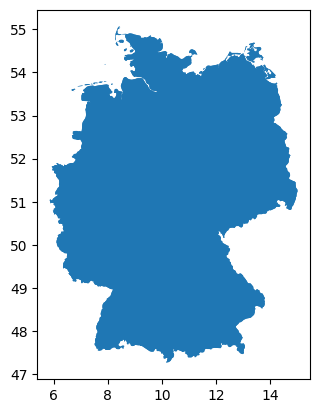

In [5]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data = workflow_germany.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot()

## Load Ökosystematlas for later raster vector join with occurrence data (optional)

This chapter is not needed and only shows that raster data is also available.

In [6]:
#Create a workflow to request the oekosystematlas raster data
workflow_oekosystematlas = ge.register_workflow({ 
    "type": "Raster",
    "operator": {
        "type": "GdalSource",
        "params": {
            "data": "oekosystematlas"
        }
    }
})

workflow_oekosystematlas

8a859eeb-0778-5190-a9d1-b1f787e4176d

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


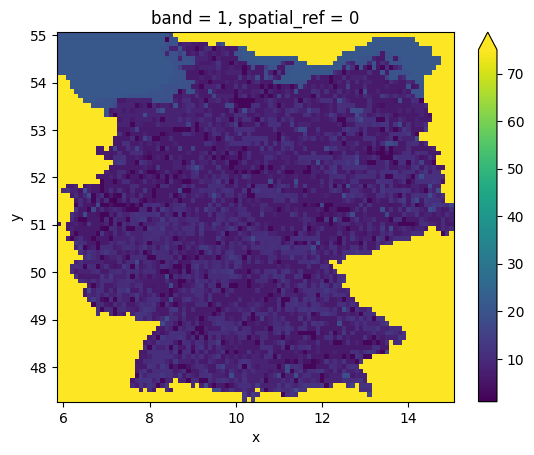

In [7]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a xarray dataarray
data = workflow_oekosystematlas.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot(vmax=75)

## Processing *Canis lupus*

None of the following steps are theoretically necessary, as the entire workflow will be projected in the nested request in the end. However, the steps are intended to show the capabilities of Geo Engine.

### Load *Canis lupus* (Optional)

In [8]:
#Create workflow to request Canis lupus incidents
workflow_canis_lupus = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": f"_:{gbif_prov_id}:`species/Canis lupus`",
        }
    }
})

workflow_canis_lupus.get_result_descriptor()

Data type:         MultiPoint
Spatial Reference: EPSG:4326
Columns:
  scientificname:
    Column Type: text
    Measurement: unitless
  gbifid:
    Column Type: int
    Measurement: unitless
  basisofrecord:
    Column Type: text
    Measurement: unitless

<Axes: >

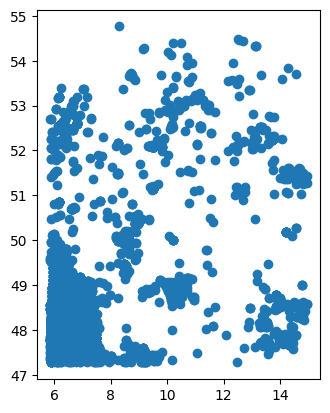

In [9]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data = workflow_canis_lupus.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot()

### Point in Polygon *Canis lupus*

In [10]:
#Create workflow to request Canis lupus incidents filtered by German border
workflow_canis_lupus_cut = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "PointInPolygonFilter",
        "params": {},
        "sources": {
            "points": { #Canis lupus ###############################
                "type": "OgrSource",
                "params": {
                    "data": f"_:{gbif_prov_id}:`species/Canis lupus`",
                    "attributeProjection": []
                } 
            }, #####################################################
            "polygons": { #Germany #################################
                "type": "OgrSource",
                "params": {
                    "data": "germany"
                }
            } ######################################################
        } 
    }
})

workflow_canis_lupus_cut

f30ac841-81b0-5301-bac6-840dd914c1ba

<Axes: >

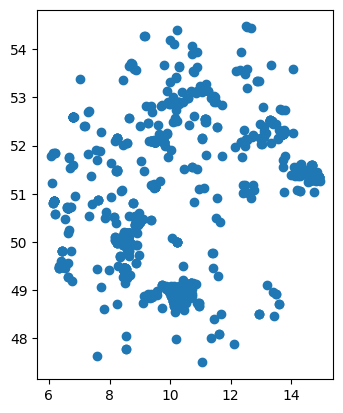

In [11]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data_canis_lupus = workflow_canis_lupus_cut.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data_canis_lupus.plot()

### Nested Point in Polygon and Raster Vector Join *Canis lupus*

In [12]:
#Create a workflow to request Canis lupus occurrences filtered by the German border and linked to the Ökosystematlas data.
workflow_canis_lupus_cut_join = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "RasterVectorJoin",
        "params": {
            "names": {
                "type": "names",
                "values": ["Ökosystematlas"]
            },  
            "temporalAggregation": "none",
            "featureAggregation": "mean",
        },
        "sources": {
            "vector": { #Canis lupus cut ######################################
                "type": "PointInPolygonFilter", 
                "params": {},
                "sources": {
                    "points": {
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`species/Canis lupus`",
                            "attributeProjection": []
                        }
                    },
                    "polygons": {
                        "type": "OgrSource",
                        "params": {
                            "data": "germany"
                        }
                    }
                }
            }, ##############################################################
            "rasters": [{ #Ökosystematlas ###################################
                "type": "GdalSource",
                "params": {
                    "data": "oekosystematlas"
                }
            }] ##############################################################
        },
    }
})

workflow_canis_lupus_cut_join

2c8ebbbc-b848-58e6-8f5c-f51976db3c8f

In [13]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data = workflow_canis_lupus_cut_join.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the geopandas dataframe
data

,geometry,basisofrecord,gbifid,scientificname,Ökosystematlas,start,end
0,POINT (9.49776 52.08503),HUMAN_OBSERVATION,3447336010,"Canis familiaris Linnaeus, 1758",10.0,NaT,NaT
1,POINT (8.63148 50.01629),HUMAN_OBSERVATION,1579887520,"Canis familiaris Linnaeus, 1758",3.0,NaT,NaT
2,POINT (9.55500 48.97333),HUMAN_OBSERVATION,1579896270,"Canis familiaris Linnaeus, 1758",12.0,NaT,NaT
3,POINT (6.14376 50.81583),HUMAN_OBSERVATION,1883797122,"Canis familiaris Linnaeus, 1758",8.0,NaT,NaT
4,POINT (10.29174 48.88160),HUMAN_OBSERVATION,1891284730,"Canis familiaris Linnaeus, 1758",10.0,NaT,NaT
...,...,...,...,...,...,...,...
1362,POINT (14.90000 51.35000),HUMAN_OBSERVATION,3725545490,"Canis lupus Linnaeus, 1758",11.0,NaT,NaT
1363,POINT (12.42115 51.19143),HUMAN_OBSERVATION,3712440633,"Canis lupus Linnaeus, 1758",2.0,NaT,NaT
1364,POINT (14.20000 51.45000),HUMAN_OBSERVATION,2837851869,"Canis lupus Linnaeus, 1758",2.0,NaT,NaT
1365,POINT (14.85000 51.35000),HUMAN_OBSERVATION,2836478160,"Canis lupus Linnaeus, 1758",6.0,NaT,NaT


It can be seen that the Ökosystematlas variable is numerical, while the classes are human-readable encoded in the metadata of the files. This can be adjusted using a class histogram

## Nested Full Workflow *Canis lupus*

In [14]:
#Create a workflow to plot Canis lupus occurrences filtered by the German border and merged with Ökosystematlas data as a class histogram.
workflow_canis_lupus_full = ge.register_workflow({
    "type": "Plot",
    "operator": {
       "type": "ClassHistogram",
       "params": {
          "columnName": "Ökosystematlas"
       },
        "sources": {
            "source": { #Canis lupus cut join #####################################
                "type": "RasterVectorJoin",
                "params": {
                        "names": {
                            "type": "names",
                            "values": ["Ökosystematlas"]
                        }, 
                        "temporalAggregation": "none",
                        "featureAggregation": "mean",
                },
                "sources": {
                    "vector": {
                        "type": "PointInPolygonFilter",
                        "params": {},
                        "sources": {
                            "points": {
                                "type": "OgrSource",
                                "params": {
                                    "data": f"_:{gbif_prov_id}:`species/Canis lupus`",
                                    "attributeProjection": []
                                }
                            },
                            "polygons": {
                                "type": "OgrSource",
                                "params": {
                                    "data": "germany"
                                }
                            }
                        }
                    },
                    "rasters": [{
                        "type": "GdalSource",
                        "params": {
                            "data": "oekosystematlas"
                        }
                    }]
                }
            } ######################################################################
       }
    }
})
    
workflow_canis_lupus_full

b182c10b-59ce-5d5b-946f-fccc3ae04c88

In [15]:
#Request the plot from Geo Engine
plot_canis_lupus = workflow_canis_lupus_full.plot_chart(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the plot
alt.Chart.from_dict(plot_canis_lupus.spec)

alt.Chart(...)

## Processing *Felis silvestris*

None of the following steps are theoretically necessary, as the entire workflow will be projected in the nested request in the end. However, the steps are intended to show the capabilities of Geo Engine.

### Load *Felis silvestris* (Optional)

In [16]:
#Create workflow to request Felis silvestris occurrences
workflow_felis_silvestris = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": f"_:{gbif_prov_id}:`species/Felis silvestris`",
        }
    }
})

workflow_felis_silvestris

f8d5abd5-7d5f-567e-97a2-7830052d6cbf

<Axes: >

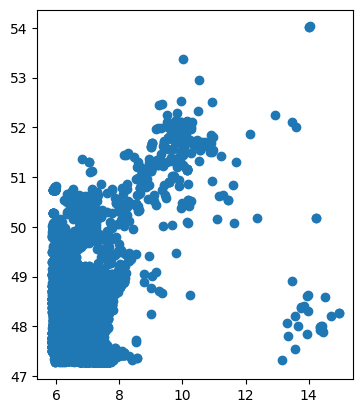

In [17]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data = workflow_felis_silvestris.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot()

### Point in Polygon *Felis silvestris*

In [18]:
#Create workflow to request Felis silvestris occurrences filtered by German border
workflow_felis_silvestris_cut = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "PointInPolygonFilter",
        "params": {},
        "sources": {
            "points": { #Felis silvestris ################################
                "type": "OgrSource",
                "params": {
                    "data": f"_:{gbif_prov_id}:`species/Felis silvestris`",
                    "attributeProjection": []
                }
            }, ###########################################################
            "polygons": { #Germany #######################################
                "type": "OgrSource",
                "params": {
                    "data": "germany"
                }
            } ############################################################
        } 
    }
})

workflow_felis_silvestris_cut

518c27b3-0ce7-56ac-b826-5a72be463a73

<Axes: >

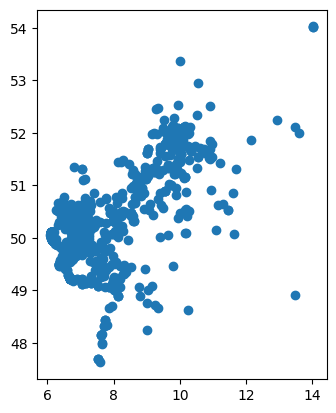

In [19]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data_felis_silvestris = workflow_felis_silvestris_cut.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data_felis_silvestris.plot()

### Nested Point in Polygon and Raster Vector Join *Felis silvestris*

In [20]:
#Create a workflow to request Felis silvestris occurrences filtered by the German border and linked to the Ökosystematlas data.
workflow_felis_silvestris_cut_join = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "RasterVectorJoin",
        "params": {
                "names": {
                    "type": "names",
                    "values": ["Ökosystematlas"]
                }, 
                "temporalAggregation": "none",
                "featureAggregation": "mean",
        },
        "sources": {
            "vector": { #Felis silvestris cut #####################################
                "type": "PointInPolygonFilter", 
                "params": {},
                "sources": {
                    "points": {
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`species/Felis silvestris`",
                            "attributeProjection": []
                        }
                    },
                    "polygons": {
                        "type": "OgrSource",
                        "params": {
                            "data": "germany"
                        }
                    }
                }
            }, ###################################################################
            "rasters": [{ #Ökosystematlas ########################################
                "type": "GdalSource",
                "params": {
                    "data": "oekosystematlas"
                }
            }] ###################################################################
        },
    }
})

workflow_felis_silvestris_cut_join

355b4e59-65cc-5cfe-a0b4-636f4d41beab

In [21]:
#Set time
time = datetime.strptime(
    '2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geo Engine into a geopandas dataframe
data = workflow_felis_silvestris_cut_join.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the geopandas dataframe
data

,geometry,basisofrecord,gbifid,scientificname,Ökosystematlas,start,end
0,POINT (7.20540 50.62800),PRESERVED_SPECIMEN,3774757358,"Felis silvestris Schreber, 1777",11.0,NaT,NaT
1,POINT (8.08720 50.78140),MATERIAL_SAMPLE,3774757042,"Felis silvestris Schreber, 1777",10.0,NaT,NaT
2,POINT (6.74050 50.43160),PRESERVED_SPECIMEN,3774755207,"Felis silvestris Schreber, 1777",8.0,NaT,NaT
3,POINT (6.36984 50.50914),HUMAN_OBSERVATION,1828993691,"Felis silvestris Schreber, 1777",14.0,NaT,NaT
4,POINT (6.92310 50.62580),PRESERVED_SPECIMEN,3774754593,"Felis silvestris Schreber, 1777",6.0,NaT,NaT
...,...,...,...,...,...,...,...
1156,POINT (6.13130 50.10320),HUMAN_OBSERVATION,3695923471,"Felis silvestris Schreber, 1777",10.0,NaT,NaT
1157,POINT (6.13130 50.10320),HUMAN_OBSERVATION,3695924066,"Felis silvestris Schreber, 1777",10.0,NaT,NaT
1158,POINT (6.13130 50.10320),HUMAN_OBSERVATION,3695924069,"Felis silvestris Schreber, 1777",10.0,NaT,NaT
1159,POINT (8.29065 50.12195),HUMAN_OBSERVATION,841588052,"Felis silvestris Schreber, 1777",11.0,NaT,NaT


## Nested Full Workflow *Felis silvestris*

In [22]:
#Create a workflow to plot Felis silvestris occurrences filtered by the German border and merged with the Ökosystematlas data as a class histogram.
workflow_felis_silvestris_full = ge.register_workflow({
    "type": "Plot",
    "operator": {
       "type": "ClassHistogram",
       "params": {
          "columnName": "Ökosystematlas"
       },
        "sources": {
            "source": {
                "type": "RasterVectorJoin",
                "params": {
                        "names": {
                            "type": "names",
                            "values": ["Ökosystematlas"]
                        }, 
                        "temporalAggregation": "none",
                        "featureAggregation": "mean",
                },
                "sources": {
                    "vector": {
                        "type": "PointInPolygonFilter",
                        "params": {},
                        "sources": {
                            "points": {
                                "type": "OgrSource",
                                "params": {
                                    "data": f"_:{gbif_prov_id}:`species/Felis silvestris`",
                                    "attributeProjection": []
                                }
                            },
                            "polygons": {
                                "type": "OgrSource",
                                "params": {
                                    "data": "germany"
                                }
                            }
                        }
                    },
                    "rasters": [{
                        "type": "GdalSource",
                        "params": {
                            "data": "oekosystematlas"
                        }
                    }]
                }
            }
       }
    }
})
    
workflow_felis_silvestris_full

db03640c-cf0e-5fe0-978c-f45a55eb5da3

In [23]:
#Request the plot from Geo Engine
plot_felis_silvestris = workflow_felis_silvestris_full.plot_chart(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the plot
alt.Chart.from_dict(plot_felis_silvestris.spec)

alt.Chart(...)

# Comparison *Canis lupus* and *Felis silvestris*

In [24]:
#Show the plot from Canis lupus
alt.Chart.from_dict(plot_canis_lupus.spec)

alt.Chart(...)

In [25]:
#Show the plot from Felis silvestris
alt.Chart.from_dict(plot_felis_silvestris.spec)

alt.Chart(...)

# Further experiments

In this chapter, some other useful links between Geo Engine and Python are shown.

In [26]:
#Comparison plots
import pandas as pd

# Convert the JSON data to pandas DataFrames
df1 = pd.DataFrame(plot_canis_lupus.spec['data']['values'])
df2 = pd.DataFrame(plot_felis_silvestris.spec['data']['values'])

df1['dataset'] = 'Canis lupus'
df2['dataset'] = 'Felis silvestris'

combined_df = pd.concat([df1, df2])

chart = alt.Chart(combined_df).mark_bar().encode(
    x=alt.X('Land Cover:N', title='Land Cover'),
    y=alt.Y('Frequency:Q', title='Frequency'),
    color=alt.Color('dataset:N', title='Dataset'),
    xOffset=alt.Color('dataset:N', title='Dataset')
).properties(width=600)

# Display the grouped barplot
chart

alt.Chart(...)

<Axes: >

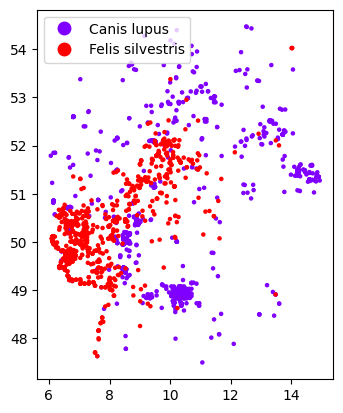

In [27]:
#Plotting of multiple species
import geopandas as gpd

gdf1 = data_canis_lupus
gdf2 = data_felis_silvestris

gdf1['dataset'] = 'Canis lupus'
gdf2['dataset'] = 'Felis silvestris'

combined_gdf = pd.concat([gdf1, gdf2])

combined_gdf.plot(column='dataset', cmap='rainbow', markersize=5, legend=True)